# Introduction to Forecasting
지난 section에서 data에 smoothing 모델을 적용하는 것을 배웠다. 이것은 다음에 일어날 것이라고 생각되는 값들을 예측하기 위한 것이였다.  
그렇다면 우리의 가장 적합한 최선의 추측은 다음달에 대한 예측일까 아님 다음 6개월 동안의 예측일까?  

이 section에서는 모델을 미래의 값을 예측하는 것으로 확장하는 방법에 대해서 공부할 예정이다. 첫번째로 우리가 해야 할 일은 train 및 test 세트로 나누고 이를 이미 답을 알고 있는 test 데이터를 통해 모델의 성능을 평가한다.  
- 이 Section의 목적
    - Holt-Winters 예측 model을 이미 알고 있는 데이터와 비교
    - Stationarity와 differencing, lagging에 대해 이해
    - ARIMA에 대한 설명과 그 다음 단계

### Simple Exponential Smoothing / Simple Moving Average
가장 기본적인 모형. $\hat y$는 데이터 집합의 가장 최근 값과 같고 예측 plot은 가장 최근 값에서 확장된 수평선
### Double Exponential Smoothing / Holt's Method
이 모델은 trend를 고려함. 여기서 예측 plot은 가장 최근 값에서 계속 이어지는 직선이지만 기울기가 존재함
### Triple Exponential Smoothing / Holt-Winters Method
이 모델은 계절성을 고려하여 (지금까지)"가장 좋아 보이는" 예측 plot을 가지고 있다. 우리가 미래에 정기적인 변동을 예상할 때, 이 모델은 계절적 패턴을 고려하여 예측하려 한다.

## Forecasting with the Holt-Winters Method
airline_passengers 데이터 셋을 사용한다. 그리고 이 data set을 108개의 training records와 36개의 testing records로 나눌 것이다.  
그리고 이 모델의 성능을 평가할 예정

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('../Data/airline_passengers.csv', 
                index_col='Month', 
                parse_dates=True)
df.index.freq = 'MS'
df.head()

,Thousands of Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [2]:
df.tail()

,Thousands of Passengers
Month,
1960-08-01,606
1960-09-01,508
1960-10-01,461
1960-11-01,390
1960-12-01,432


## Train Test Split

In [3]:
train_data = df.iloc[:109]
test_data = df.iloc[108:]

## Fitting the Model

In [4]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

fitted_model = ExponentialSmoothing(train_data['Thousands of Passengers'], 
                                   trend='mul',
                                   seasonal='mul',
                                   seasonal_periods=12).fit()

## Evaluating Model against Test Set

In [5]:
test_predictions = fitted_model.forecast(36)
test_predictions.head()

1958-02-01    331.649486
1958-03-01    388.989620
1958-04-01    380.125229
1958-05-01    388.290919
1958-06-01    453.379219
Freq: MS, dtype: float64

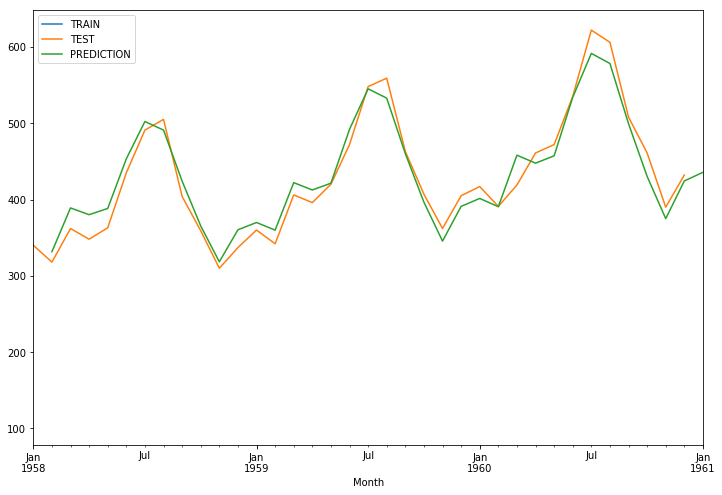

In [6]:
train_data['Thousands of Passengers'].plot(legend=True, label='TRAIN', figsize=(12, 8))
test_data['Thousands of Passengers'].plot(legend=True, label='TEST')
test_predictions.plot(legend=True, label='PREDICTION', xlim=['1958-01-01', '1961-01-01']);

## Evalutaion Metrics

In [7]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [8]:
test_data.describe()

,Thousands of Passengers
count,36.000000
mean,428.500000
std,79.329152
min,310.000000
25%,362.000000
50%,412.000000
75%,472.000000
max,622.000000


In [9]:
mean_absolute_error(test_data, test_predictions)

46.30290459904356

In [10]:
mean_squared_error(test_data, test_predictions)

3075.328474184122

In [11]:
# RMSE가 실제 데이터의 표준 편차(test_data.describe())보다 작아 예측 성능이 꽤 좋다는 것을 의미한다.
np.sqrt(mean_squared_error(test_data, test_predictions))

55.45564420493303

## Forecasting into Future

In [12]:
# 미래를 예측하기 위한 모델 재 훈련
final_model = ExponentialSmoothing(df['Thousands of Passengers'], 
                                  trend='mul',
                                  seasonal='mul',
                                  seasonal_periods=12).fit()

In [13]:
forecast_predictions = final_model.forecast(36)

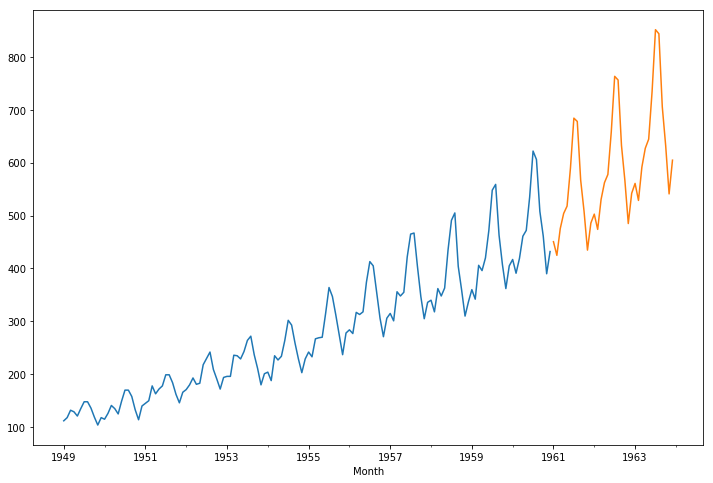

In [14]:
df['Thousands of Passengers'].plot(figsize=(12, 8))
forecast_predictions.plot();

# Stationary
Time series에서 불리는 *Stationary*(정상성)은 데이터에 trends와 seasonality가 보이지 않을 때를 말한다.  
즉, 평균과 분산 그리고 공분산은 Time series에 모든 부분에 대해 동일해야 하며 시간에 대한 함수가 아니다.

In [15]:
df2 = pd.read_csv('../Data/samples.csv', 
                 index_col=0,
                 parse_dates=True)
df2.head()

,a,b,c,d
1950-01-01,36,27,0,67
1950-02-01,58,22,3,31
1950-03-01,61,17,5,67
1950-04-01,37,15,8,47
1950-05-01,66,13,8,62


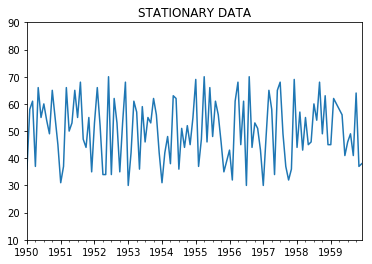

In [16]:
# 계절성이나 트렌드가 보이지 않는다.
# 이 데이터가 평균적으로 증가/감소하는 것을 명확히 확인할 수 없으며 어떠한 명확한 계절성이나 반복도 보이지 않음
df2['a'].plot( ylim=[10, 90], title='STATIONARY DATA').autoscale(axis='x', tight=True);

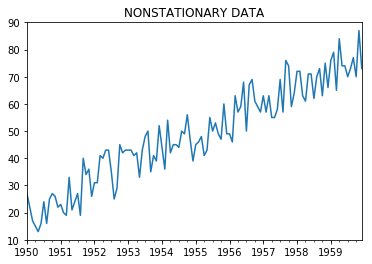

In [17]:
# 계절성을 띄는 것처럼 보이지 않지만 전반에 걸쳐 명확한 추세가 관찰됨
# 평균적으로 이 값들의 추세가 증가하고 있다.
df2['b'].plot( ylim=[10, 90], title='NONSTATIONARY DATA').autoscale(axis='x', tight=True);

# Differencing
## First Order Differencing
Non-stationary data일지라도 *differencing*(차분)을 통해 stationary data로 만들 수 있다. 가장 단순한 차분인 *first order differencing*는 아래의 식과 같이 연속된 관측치 간의 차이를 계산한다.

&nbsp;&nbsp;&nbsp;&nbsp;$y^{\prime}_t = y_t - y_{t-1}$

이러한 방식으로 linear trend는 수평적인 값의 집합으로 변환 됨

In [18]:
from statsmodels.tsa.statespace.tools import diff

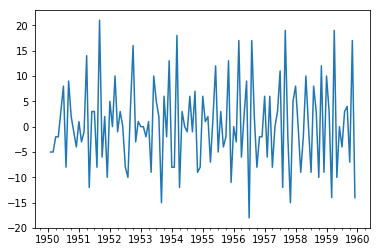

In [19]:
# df2['b'] - df2['b'].shift(1)
diff(df2['b'], k_diff=1).plot();